# Autonomous Driving Environment for Reinforcement Learning

## Setting up the Environment

Clone the `ai4r-gym` environment from the git repository:

In [ ]:
# !git clone https://gitlab.unimelb.edu.au/asclinic/ai4r-gym.git

Installing dependencies:

In [ ]:
!pip install gymnasium>=0.28.0 stable_baselines3
!pip install sb3_contrib

Change directory into the ai4r-gym to make the gym environments available to us:

In [ ]:
%cd ai4r-gym

/content/ai4r-gym


Library Imports

In [ ]:
!pip install optuna

In [ ]:
import ai4rgym
import gymnasium as gym
import numpy as np

from stable_baselines3 import PPO, SAC, DDPG, TD3, A2C
from sb3_contrib import TRPO, RecurrentPPO, MaskablePPO

import matplotlib.pyplot as plt

from utils import *

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
import optuna

## Autonomous Driving Environment

The Autonomous driving environment is defined by the class `AutonomousDrivingEnv` located in `ai4rgym/envs/autonomous_driving_env.py`.

This environment follows the gymnasium environment format for reinforcement learning provided by Farama Foundation. It inherits the `gym.Env` class and contains the necessary functions such as `reset()` and `set()` for the gym environment.

Skeleton:

```Python
class AutonomousDrivingEnv(gym.Env):
    def __init__(self):
        # Initialization function
    
    def reset(self, seed = None, options = None):
        # Resets the position of the car
        # And generates an observation
        return observation, info_dict

    
    def step(self, action):
        # Steps forward the car by one time increment
        # Given the action
        # Gets the new observation and reward
        return observation, reward, terminated, truncated, info_dict
    
    # ... other getter, setter, helper functions

```

The Autonomous Driving Environment uses two more classes -

1. `BicycleModelDynamic` - Used to define the behavior of the Car using a Dynamic Bicycle Model. This uses the Pacejka tyre model.
2. `Road` - Used to define the road environment.


### Dynamic Bicycle Model

```Python

class BicycleModelDynamic:
    def __init__(self):
        # Initialization function
    

    def reset(self):
        # Reset the states, actions, and requested actions

    def set_action_requests(self, drive_command_request, delta_request):
        # Set the action request values
    
    def eom_kinematic_bicycle(t, s, a, mp):
        # Compute the equations of motion for the dynamic bicycle model
    
    def perform_integration_step(self, ...):
        # Performs numerical integration
        # Using multiple time-steps if specified
        # To approximate the state after Ts seconds

        # Return the state components
        return s[0], s[1], s[2] , s[3] , s[4] , s[5] , s[6]
    
    # other methods: get_actions(), render_car()


```


### Road:

```Python

class Road:
    def __init__(self):
        # Initialization function
    
    def add_road_element_straight():
        ...
    
    def add_road_element_curved_by_length():
        ...
    
    def add_road_element_curved_by_angle():
        ...
    
    ...

    # Other methods

```

## Defining a Minimal Environment

### SPECIFY THE VEHICLE PARAMETERS

Dictionary with car specifications,
in the form of a dynamic bicycle model


The model parameters above are based on a Telsa Model 3:
> Source: https://www.tesla.com/ownersmanual/model3/en_cn/GUID-E414862C-CFA1-4A0B-9548-BE21C32CAA58.html  
> Source: https://www.tesla.com/sites/default/files/blog_attachments/the-slipperiest-car-on-the-road.pdf

The Pacejka's tyre formula coefficients default to the value from here
> Source: https://www.edy.es/dev/docs/pacejka-94-parameters-explained-a-comprehensive-guide/  
> https://au.mathworks.com/help/sdl/ref/tireroadinteractionmagicformula.html  


In [ ]:

bicycle_model_parameters = {
    "Lf" : 0.55*2.875,
    "Lr" : 0.45*2.875,
    "m"  : 2000.0,
    "Iz" : (1.0/12.0) * 2000.0 * (4.692**2+1.850**2),
    "Cm" : (1.0/100.0) * (1.0 * 400.0 * 9.0) / 0.2286,
    "Cd" : 0.5 * 0.24 * 2.2204 * 1.202,
    "delta_offset" : 0 * np.pi/180,
    "delta_request_max" : 45 * np.pi/180,
    "Ddelta_lower_limit" : -45 * np.pi/180,
    "Ddelta_upper_limit" :  45 * np.pi/180,
}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### SPECIFY THE ROAD

Specified as a list of dictionaries, where each
element in the list specifies a segment of the road.
Example segment dictionaries:
```
> {"type":"straight", "length":3.0}
> {"type":"curved", "curvature":1/50.0, "angle_in_degrees":45.0}
> {"type":"curved", "curvature":1/50.0, "length":30.0}

```

In [ ]:
# road_elements_list = [
#     {"type":"straight", "length":200.0},
#     {"type":"curved", "curvature":1/100.0, "angle_in_degrees":180.0},
#     {"type":"straight", "length":200.0},
#     {"type":"curved", "curvature":-1/50.0, "angle_in_degrees":180.0},
#     {"type":"straight", "length":100.0},
# ]

road_elements_list = [
    {"type":"straight", "length":100.0},
    {"type":"curved", "curvature":1/80.0, "angle_in_degrees":120.0},
    {"type":"straight", "length":50.0},
    {"type":"curved", "curvature":-1/25.0, "angle_in_degrees":100.0},
    {"type":"straight", "length":50.0},
    {"type":"curved", "curvature":1/25.0, "angle_in_degrees":100.0},
    {"type":"straight", "length":50.0},
    {"type":"curved", "curvature":-1/50.0, "angle_in_degrees":180.0},
    {"type":"straight", "length":100.0},
    {"type":"curved", "curvature":1/50.0, "angle_in_degrees":100.0},
    {"type":"straight", "length":50.0},
    {"type":"curved", "curvature":1/20.0, "angle_in_degrees":90.0},
]

### SPECIFY THE NUMERICAL INTEGRATION DETAILS

The options available for the numerical
integration method are:
```["euler", "huen", "midpoint", "rk4", "rk45"]```


In [ ]:
numerical_integration_parameters = {
    "method" : "rk4",
    "Ts" : 0.05,
    #"num_steps_per_Ts" : 1,
}

### SPECIFY THE INITIAL STATE DISTRUBTION

The initial state is sampled from a uniform
distribution between the minimum and maximum
(i.e., between lower and upper bounds)
> Note: a factor of (1/3.6) converts from units
  of [km/h] to [m/s]

In [ ]:
py_init_min = -1.0
py_init_max =  1.0

v_init_min_in_kmh = 25.0
v_init_max_in_kmh = 35.0

initial_state_bounds = {
    "px_init_min" : 0.0,
    "px_init_max" : 0.0,
    "py_init_min" : py_init_min,
    "py_init_max" : py_init_max,
    "theta_init_min" : 0.0,
    "theta_init_max" : 0.0,
    "vx_init_min" : v_init_min_in_kmh * (1.0/3.6),
    "vx_init_max" : v_init_max_in_kmh * (1.0/3.6),
    "vy_init_min" : 0.0,
    "vy_init_max" : 0.0,
    "omega_init_min" : 0.0,
    "omega_init_max" : 0.0,
    "delta_init_min" : 0.0,
    "delta_init_max" : 0.0,
}

### INITIALIZE THE AUTONOMOUS DRIVING ENVIRONMENT

In [ ]:
env = gym.make(
    "ai4rgym/autonomous_driving_env",
    render_mode=None,
    bicycle_model_parameters=bicycle_model_parameters,
    road_elements_list=road_elements_list,
    numerical_integration_parameters=numerical_integration_parameters,
    initial_state_bounds=initial_state_bounds,
)

## Reinforcement Learning on our Autonomous Driving Env

Creating our own Gymnasium Environment where the car is driving on a road using the Dynamic Bicycle Model:

In [ ]:
# env = gym.make(
#     "ai4rgym/autonomous_driving_env",
#     render_mode=None,
#     bicycle_model_parameters=bicycle_model_parameters,
#     road_elements_list=road_elements_list,
#     numerical_integration_parameters=numerical_integration_parameters,
#     initial_state_bounds=initial_state_bounds,
# )

Before we try to run our existing example, let's take a look at the Action Space and the Observation Space of our environment:

### Observation Space

In [ ]:
#observation_space = env.observation_space
#observation, info_dict = env.reset()

In [ ]:
#observation_space

In [ ]:
#observation

**Gymnasiuam requires the `MultiInputPolicy` policy type for observations with multiple inputs in a `Dictionary` data type.**

### Action Space

Let's take a look at the action space and take a look at a random action:

In [ ]:
#action_space = env.action_space
#random_action = action_space.sample()

#observation, reward, terminated, truncated, info_dict = env.step(random_action)

In [ ]:
#action_space

In [ ]:
#random_action

What happens if we try to use the existing environment with a gym policy?

In [ ]:
#model = PPO("MultiInputPolicy", env, verbose = 1)

We are getting this error because **Gymnasium does not support Dictionary Action Spaces at the moment**

What is the solution? **Use a wrapper to convert the action space into a `gym.Box` Data Type.**

### Flatten Action Wrapper

In [ ]:
class FlattenActionWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super(FlattenActionWrapper, self).__init__(env)

        # Get the low and high values from the original action spaces
        drive_low = env.action_space.spaces['drive_command'].low
        drive_high = env.action_space.spaces['drive_command'].high
        delta_low = env.action_space.spaces['delta_request'].low
        delta_high = env.action_space.spaces['delta_request'].high

        # Define the new flat Box action space
        low = np.concatenate([drive_low, delta_low])
        high = np.concatenate([drive_high, delta_high])
        self.action_space = gym.spaces.Box(low=low, high=high, dtype=np.float32)

    def action(self, action):
        # Split the flat action array into the original Dict format
        drive_action, delta_action = action
        dict_action = {
            'drive_command': drive_action,
            'delta_request': delta_action,
        }
        return dict_action


Let's wrap the Flatten Action wrapper around the `env` and see if the model works.

In [ ]:
#env = FlattenActionWrapper(env)

In [ ]:
#env.action_space.sample()

Rescale Flatten Action Wrapper between -1 and 1

In [ ]:
#env = gym.wrappers.RescaleAction(env, min_action=-1, max_action=1)

In [ ]:
#model = PPO("MultiInputPolicy", env, verbose = 1)

#### States

That is great news, now we are ready to train our model/policy. But before that, in a similar fashion, we can also modify the observation and the rewards.

States from the Car model:

```
States:
- px     :  x-position in the world frame (units: m)
- py     :  y-position in the world frame (units: m)
- theta  :  angle of car body relative to x-axis of the world frame (units: rad)
- vx     :  x-velocity in the body frame (units: m/s)
- vy     :  y-velocity in the body frame (units: m/s)
- omega  :  angular velocity of car body (units: rad/s)
- delta  :  steering angle of front wheel relative of the body of the car (units: rad)
```

Additional states from the `info_dict`

    info_dict : dictionary
        Containing details for the road relative to the current
        state of the car.
        The properties of the info_dict are:
        - "px", "py" : float
            World-frame (x,y) coordinate of the car.
        - "px_closest", "py_closest" : float
            World-frame (x,y) coordinate of the closest point on the road.
        - "closest_distance" : float
            Euclidean distance from the car to the closest point on the road.
        - "side_of_the_road_line" : int
            The side of the road that the car is on (1:=left, -1=right).
        - "progress_at_closest_p" : float
            The total length of road from the start of the road to the closest point.
        - "road_angle_at_closest_p" : float
            The angle of the road at the closest point (relative to the world-frame x-axis).
        - "closest_element_idx" : int
            The index of the road element that is closest to the car.
        - "progress_queries" : numpy array, 1-dimensional
            A repeat of the input parameter that specifies the values of progress-along-the-road,
            relative to the current position of the car, at which the observations should be generated.
        - "road_points_in_body_frame" : numpy array, 2-dimensional
            (px,py) coordinates in the body frame of the progress query points.
            A 2-dimensional numpy array with: size = number of query points -by- 2.
        - "road_angles_relative_to_body_frame" : numpy array, 1-dimensional
            Angle of the road, relative to the body frame, at each of the progress query points.
            A 1-dimensional numpy array with: size = number of query points.

        Units: all length in meters, all angles in radians.

Let's create a custom observation which takes into account 3 main observations:

1. Distance of the car from the closest point of the road
2. The difference in angle between the car's heading and the tangent of the road at the closest point
3. The curvature of the road at the closest point

### Observation Wrapper

In [ ]:
class CustomObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        """
        Initialization function,
        initializes a new observation space as a dictionary of boxes

        New Observations
        ----------------

            - distance_to_center: Closest distance of the car from the center
                of the road. This is also multiplied by the side_of_the_road
                to identify if the car is to the left/right side of the center
                of the road
            - angle_diff: The difference in angle between the car's heading
                and the tangent of the road at the closest point
            - curvature_at_closest_p: The curvature of the road at the closest
                point.

        Adding observations:
        --------------------
        If you chose to add more observations, create a `gym.spaces.Box`
            corresponding to your observation with the `low` and `high` values

        """

        super(CustomObservationWrapper, self).__init__(env)

        self.DISTANCE_SCALE = 1
        self.ANGLE_SCALE = 1
        self.CURVATURE_SCALE = 1

        # Update the observation space to include new observations
        # You need to remove the spaces that are not returned in the new observation and add the new ones.
        self.observation_space = gym.spaces.Dict({
            'distance_to_road': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'angle_diff': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'curvature_at_closest_p': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
        })

        # Other observations that you might consider including but not limited to:
        # - The progress queries from self.progress_queries
        #   Which will allow the model to look ahead
        # - Current progress (find it from the info_dict)
        # - Velocity/Angular velocity of the car (self.env.car.vx/vy/omega)
        # - Position/Orientation in real-world co-ordinates (self.env.car.px/py/theta)
        # - Current steering anlge (self.env.car.delta)
        # - Other observations from the info_dict and/or custom observations

        # Note that more observations will add to the complexity of the model

    def observation(self, observation):
        """
        This is the method that receives the original observation from the
        default environment and returns a modified dictionary of observations

        Returns:
        --------
            - Dictionary of new observation

        Adding observations:
        --------------------
            - Compute the observation from the car/info_dict
            - Add a corresponding np.array() to the `new_observation` dict

        """

        # This method receives the original observation, and your task is to return the modified observation
        info_dict = self.env.road.road_info_at_given_pose_and_progress_queries(
            px=self.env.car.px, py=self.env.car.py, theta=self.env.car.theta, progress_queries=self.progress_queries)

        distance_to_road = info_dict['closest_distance'] * info_dict['side_of_the_road_line'] / self.DISTANCE_SCALE
        angle_diff = (info_dict['road_angle_at_closest_p'] - self.env.car.theta) / self.ANGLE_SCALE
        curvature_at_closest_p = self.env.road.get_c()[info_dict['closest_element_idx']] / self.CURVATURE_SCALE

        # print(info_dict)

        # print("TEST")
        # print("angle_diff:", angle_diff)

        new_observation = {
            'distance_to_road': np.array([distance_to_road], dtype=np.float32),
            'angle_diff': np.array([angle_diff], dtype=np.float32),
            'curvature_at_closest_p': np.array([curvature_at_closest_p], dtype=np.float32),
        }

        return new_observation

Let's wrap the environment with the `CustomObservationWrapper`:

In [ ]:
#env = CustomObservationWrapper(env)

In [ ]:
#env.observation_space

### Custom Reward Wrapper

**Let's formulate a Custom reward:**

Positive Rewards:   
    - `progress_at_closest_p` - `previous_progress_at_closest_p` : This will make sure that the car has a positive progress along the road in each time step i.e. the car moves forward.

Negative Rewards (Penalties):   
    - `np.sqrt(info_dict["closest_distance"]**2)`: This penalizes the car for moving too far from the center of the line.     
    - Apply a speed limit penalty such that `100` negative rewards are applied
        whenever the car exceeds 100kph.

In [ ]:
def distance_reward(d: float) -> float:
    """
    Calculate the reward based on the distance to the center of the road.

    Parameters:
    d (float): Distance to the center of the road in meters.

    Returns:
    float: Reward value.
    Maximum value of reward: 3, goes to negative for distances > 2
    """

    a = 60
    b = 5

    return -1 * (d - 0) + b

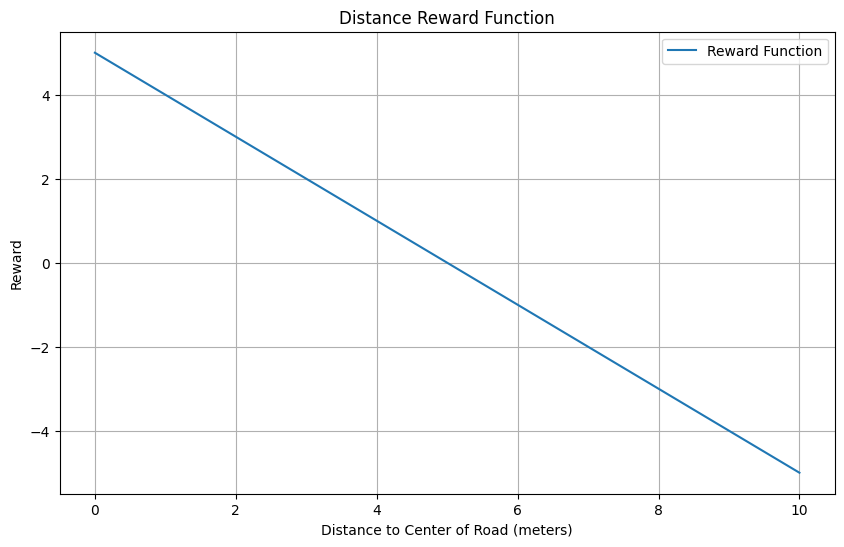

In [ ]:
# Generate an array of distances from 0 to 3
distances = np.linspace(0, 10, 300)

# Calculate the reward for each distance
rewards = [distance_reward(d) for d in distances]

# Plot the function
plt.figure(figsize=(10, 6))
plt.plot(distances, rewards, label="Reward Function")
plt.title("Distance Reward Function")
plt.xlabel("Distance to Center of Road (meters)")
plt.ylabel("Reward")
plt.grid(True)
# plt.axvline(x=0.5, color='r', linestyle='--', label="Distance = 0.5")
# plt.axvline(x=2, color='g', linestyle='--', label="Distance = 2")
plt.legend()
plt.show()

In [ ]:
def speed_reward(speed):
    """
    Custom reward function for an autonomous car to encourage maintaining
    a good speed and discourage overspeeding.

    Parameters:
    speed (float): The speed of the car in kmph.

    Returns:
    float: The reward corresponding to the input speed.
    Maximum reward: 300
    """
    # Coefficients derived from solving the equations
    a = 1/12  # Coefficient for the quadratic function in the first and second segments
    b = 300  # Offset for the quadratic function in the first segment
    e = 10  # Coefficient for the linear function in the third segment
    offset = e * 25


    if 0 <= speed < 25:
        return e * (speed - 25) + offset # Upward facing quadratic function for 0 to 60 kmph
    elif 25 <= speed < 80:
        return offset  # Downward facing quadratic function for 60 to 120 kmph
    else:
        return -e * (speed - 80) + offset # Linear decreasing function for speed above 120 kmph

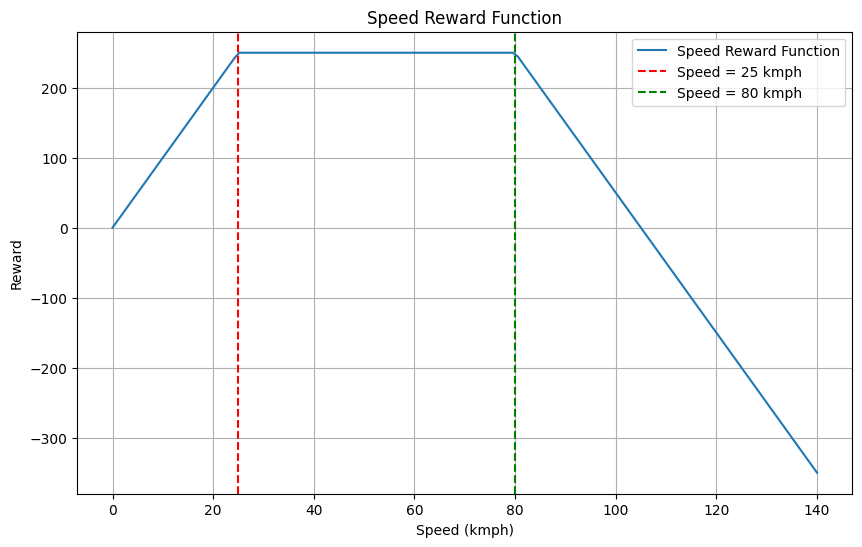

In [ ]:
# Generate an array of speeds from 0 to 140
speeds = np.linspace(0, 140, 140)

# Calculate the reward for each speed
speed_rewards = [speed_reward(s) for s in speeds]

# Plot the function
plt.figure(figsize=(10, 6))
plt.plot(speeds, speed_rewards, label="Speed Reward Function")
plt.title("Speed Reward Function")
plt.xlabel("Speed (kmph)")
plt.ylabel("Reward")
plt.grid(True)
plt.axvline(x=25, color='r', linestyle='--', label="Speed = 25 kmph")
plt.axvline(x=80, color='g', linestyle='--', label="Speed = 80 kmph")
plt.legend()
plt.show()

In [ ]:
#ARYA - change this to be like dist and angle reward

# def road_progress_reward(prev_progress, progress):
#   """Reward for making forward progress along road."""

#   return 10*(progress - prev_progress)





# def smooth_steering_reward(current_steering_angle, prev_steering_angle)-> float:
#   """Penalize large changes in steering angle, which would encourage smoother steering."""


#   STEER_THRESHOLD = 0.1 # Max change in steer angle

#   steer_diff = abs(current_steering_angle - prev_steering_angle)


#   steer_penalty = max(0, steer_diff - STEER_THRESHOLD)**2

#   return -5 * steer_penalty





def smooth_steering_reward(steer_diff: float)-> float:
  """Penalize large changes in steering angle, which would encourage smoother steering."""
  a = 60
  b = 3
  # print(f"smooth_steering_reward | steer_diff = {steer_diff} ")

  STEER_THRESHOLD = 0.1 # Max change in steer angle

  # steer_diff = abs(current_steering_angle - prev_steering_angle)

  return -a * (steer_diff - 0) + b





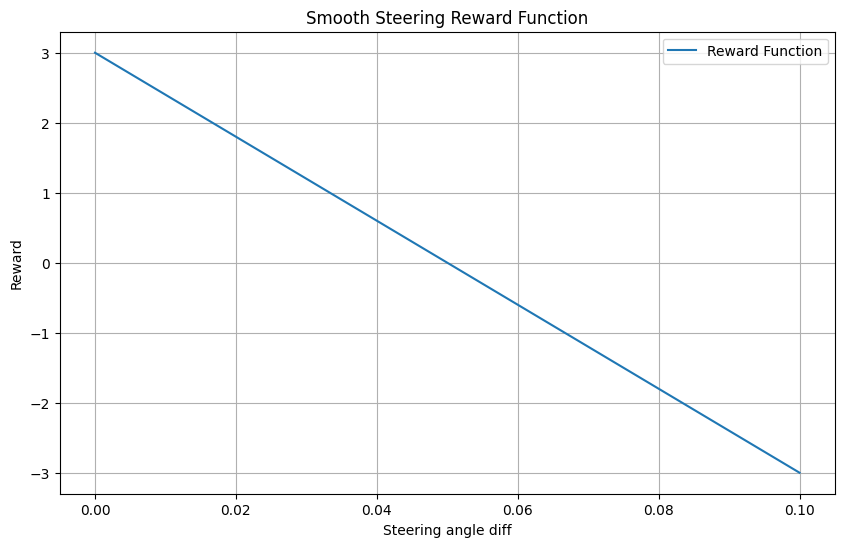

In [ ]:
# Generate an array of distances from 0 to 3
angles = np.linspace(0, 0.1, 300)

# Calculate the reward for each distance
rewards = [smooth_steering_reward(a) for a in angles]

# Plot the function
plt.figure(figsize=(10, 6))
plt.plot(angles, rewards, label="Reward Function")
plt.title("Smooth Steering Reward Function")
plt.xlabel("Steering angle diff")
plt.ylabel("Reward")
plt.grid(True)
# plt.axvline(x=0.5, color='r', linestyle='--', label="Angle = 0.5")
plt.legend()
plt.show()

In [ ]:
def angle_reward(angle: float) -> float:
    # Define the coefficients
    a = 5.0
    b = 1.5
    c = 2.0

    return -a * (angle - 0.2) + b



# def angle_reward(angle: float) -> float:
#     a = 5
#     print(angle)
#     ANGLE_THRESHOLD = 0.1 # Max change in steer angle



#     angle_penalty = max(0, angle - ANGLE_THRESHOLD)**2
#     print(-a * angle_penalty)
#     return -a * angle_penalty

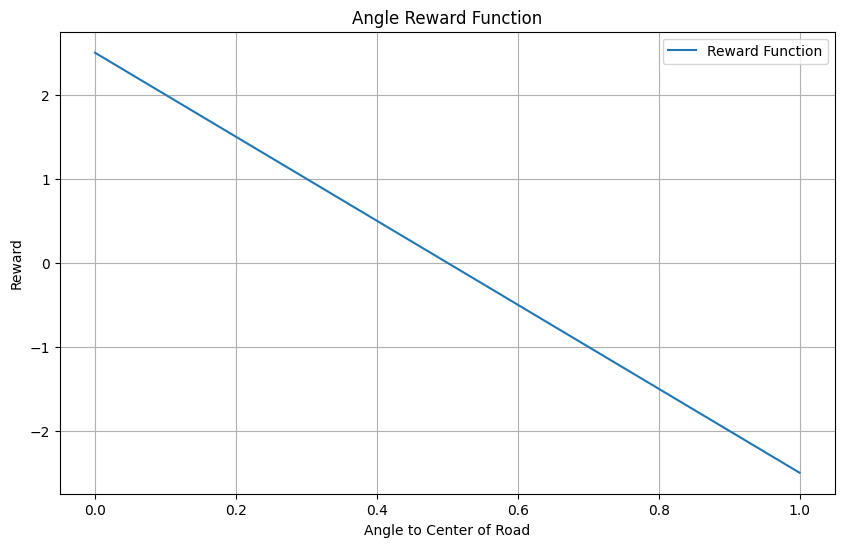

In [ ]:
# Generate an array of distances from 0 to 3
angles = np.linspace(0, 1, 300)

# Calculate the reward for each distance
rewards = [angle_reward(a) for a in angles]

# Plot the function
plt.figure(figsize=(10, 6))
plt.plot(angles, rewards, label="Reward Function")
plt.title("Angle Reward Function")
plt.xlabel("Angle to Center of Road")
plt.ylabel("Reward")
plt.grid(True)
# plt.axvline(x=0.5, color='r', linestyle='--', label="Angle = 0.5")
plt.legend()
plt.show()

In [ ]:
# class CustomRewardWrapper(gym.RewardWrapper):
#     def __init__(self, env):
#         super(CustomRewardWrapper, self).__init__(env)
#         # self.roadloss = RoadLoss(a1 = 0.1, a2 = 1, a3 = 10)

#     def reward(self, reward):
#         """
#         Modify the reward value given by the environment.

#         Parameters
#         ----------
#         reward : float
#             The reward returned by the environment.

#         Returns
#         -------
#         modified_reward : float
#             The modified reward.
#         """
#         info_dict = self.env.road.road_info_at_given_pose_and_progress_queries(
#             px=self.env.car.px, py=self.env.car.py, theta=self.env.car.theta, progress_queries=self.progress_queries)


#         progress_delta = reward                                                 # This is the default reward (current progress - previous progress)

#         modified_reward = progress_delta*1000                                   # Multiply by 1000 so that it's in a range ~300-400 depending on speed

#         # Distance reward
#         # modified_reward += distance_reward(info_dict["closest_distance"])*100    # Multiply by 100 so that the maximum reward is in a range ~300

#         ### OUR CODE
#         # print("TEST reward function:", self.observation_space['angle_diff'])
#         modified_reward += angle_reward((info_dict['road_angle_at_closest_p'] - self.env.car.theta) / self.ANGLE_SCALE)*100
#         # (info_dict['road_angle_at_closest_p'] - self.env.car.theta) / self.ANGLE_SCALE

#         # Speed limit reward
#         modified_reward += speed_reward(self.env.car.vx*3.6)                    # Multiply the vx by 3.6 to convert to kph; no need to multiply the reward because reward max is already ~300

#         return modified_reward

In [ ]:
#ARYA
class CustomRewardWrapper(gym.RewardWrapper):
    def __init__(self, env):
        super(CustomRewardWrapper, self).__init__(env)
        self.previous_steering_angle = None
        # self.roadloss = RoadLoss(a1 = 0.1, a2 = 1, a3 = 10)
        self.total_reward = 0


    def reward(self, reward):
        # ARYA: note the scaling factor for each reward
        """
        Modify the reward value given by the environment.

        Parameters
        ----------
        reward : float
            The reward returned by the environment.

        Returns
        -------
        modified_reward : float
            The modified reward.
        """

        info_dict = self.env.road.road_info_at_given_pose_and_progress_queries(
            px=self.env.car.px, py=self.env.car.py, theta=self.env.car.theta, progress_queries=self.progress_queries)


        progress_delta = reward                                                 # This is the default reward (current progress - previous progress)
        # print(progress_delta*1000)
        modified_reward = 1.25 * progress_delta*1000                                   # Multiply by 1000 so that it's in a range ~300-400 depending on speed
        # print(modified_reward)
        # Distance reward

        modified_reward +=  1.1* distance_reward(info_dict["closest_distance"])*80    # Multiply by 100 so that the maximum reward is in a range ~300 (Arya: dist can go down to 10)

        # print(f"closest distance = {info_dict['closest_distance']} | distance_reward = {distance_reward(info_dict['closest_distance'])*75}")
        ### OUR CODE
        # print("TEST reward function:", self.observation_space['angle_diff'])
        # print(f"JAJAJ {info_dict['road_angle_at_closest_p']} {self.env.car.theta}")

        car_road_angle_diff = abs(info_dict['road_angle_at_closest_p'] - self.env.car.theta)

        # angle scale is just 1

        modified_reward += angle_reward(car_road_angle_diff) * 100

        #  Add smoothness reward
        if self.previous_steering_angle is not None:
            steering_angle_diff = abs(self.env.car.delta - self.previous_steering_angle)
            modified_reward += smooth_steering_reward(steering_angle_diff) * 50  #multiply 35 so it is in range ~ 100
        self.previous_steering_angle = self.env.car.delta

        # Speed limit reward
        modified_reward += 1.15* speed_reward(abs(self.env.car.vx)*3.6)  * 0.5       # Multiply the vx by 3.6 to convert to kph; no need to multiply the reward because reward max is already ~300
        modified_reward += 1.15* speed_reward(abs(self.env.car.vy)*3.6)  * 0.5

        # self.total_reward += modified_reward
        # print(self.total_reward)

        return modified_reward

In [ ]:
#env = CustomRewardWrapper(env)

### Terminate & Truncate Wrapper

In [ ]:
class TerminateTruncateWrapper(gym.Wrapper):
    def __init__(self, env, terminate_distance_threshold = 10):
        super(TerminateTruncateWrapper, self).__init__(env)
        self.AVG_SPEED = 20/3.6 # 20 KPH converted to m/s
        self.timestep = 0
        self.TERM_DIST_THRESH = terminate_distance_threshold
        self.MAX_STEPS_PER_EPISODE = self.calculate_max_steps()
        #print("Maximum steps per episode: {}".format(self.MAX_STEPS_PER_EPISODE))

    def step(self, action):
        observation, reward, terminated, truncated, info_dict = self.env.step(action)
        self.timestep += 1
        terminated = self.get_updated_terminated_flag(terminated)
        truncated = self.get_updated_truncated_flag(truncated)
        return observation, reward, terminated, truncated, info_dict

    def reset(self, seed = None, options = None):
        self.timestep = 0
        return self.env.reset(seed = seed, options = options)

    def calculate_max_steps(self):
        return (self.env.road.get_total_length()/self.AVG_SPEED)//self.env.integration_Ts

    def get_updated_terminated_flag(self, terminated):
        # updated logic for termination
        info_dict = self.env.road.road_info_at_given_pose_and_progress_queries(
                    px=self.env.car.px, py=self.env.car.py, theta=self.env.car.theta, progress_queries=self.progress_queries)
        distance_to_center = info_dict['closest_distance']
        if distance_to_center > self.TERM_DIST_THRESH:
            terminated = True
        return terminated

    def get_updated_truncated_flag(self, truncated):
        if self.timestep > self.MAX_STEPS_PER_EPISODE:
            truncated = False
        return truncated

In [ ]:
#env = TerminateTruncateWrapper(env)

## Training Loop

Setup Environment

In [ ]:
env = gym.make(
    "ai4rgym/autonomous_driving_env",
    render_mode=None,
    bicycle_model_parameters=bicycle_model_parameters,
    road_elements_list=road_elements_list,
    numerical_integration_parameters=numerical_integration_parameters,
    initial_state_bounds=initial_state_bounds,
)

Wrappers

In [ ]:
env = FlattenActionWrapper(env)
env = gym.wrappers.RescaleAction(env, min_action=-1, max_action=1)
env = CustomObservationWrapper(env)
env = CustomRewardWrapper(env)
env = TerminateTruncateWrapper(env)

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.road to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.road` for environment variables or `env.get_wrapper_attr('road')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.integration_Ts to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.integration_Ts` for environment variables or `env.get_wrapper_attr('integration_Ts')` that will search the reminding wrappers.
  logger.warn(


Directory Setup

In [ ]:
RL_MODEL = "PPO"

In [ ]:
model_name = f"{RL_MODEL}_1"

TIMESTEPS_PER_EPOCH = 5000  #put around 5000 for testing | 20000 for full training
EPOCHS = 3 # put around 3 for testing | 5 for full

logdir = "logs"
models_dir = f"models/{model_name}"
figs_dir = f"models/{model_name}/figs"

ensure_dirs([logdir, models_dir, figs_dir])

[I 2023-11-11 00:59:23,925] A new study created in memory with name: no-name-d405babd-2870-4213-a6c4-ca69bf7acd8b


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Current trial parameters: {'learning_rate': 0.0003, 'batch_size': 64}
Logging to logs/PPO_1_0


/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.road to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.road` for environment variables or `env.get_wrapper_attr('road')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.car to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.car` for environment variables or `env.get_wrapper_attr('car')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.progress_queries to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.progress_queries` for environment variables or `env.get_wrapper_attr('progress_queries')` tha

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 110      |
|    ep_rew_mean     | 7.76e+04 |
| time/              |          |
|    fps             | 245      |
|    iterations      | 1        |
|    time_elapsed    | 8        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 124          |
|    ep_rew_mean          | 9.06e+04     |
| time/                   |              |
|    fps                  | 152          |
|    iterations           | 2            |
|    time_elapsed         | 26           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0027002827 |
|    clip_fraction        | 0.00688      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 1.01e-06     |
|    learning_r

[I 2023-11-11 01:00:02,800] Trial 0 finished with value: 1.0 and parameters: {'learning_rate': 0.0003, 'batch_size': 64}. Best is trial 0 with value: 1.0.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Current trial parameters: {'learning_rate': 0.0003, 'batch_size': 32}
Logging to logs/PPO_1_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 141      |
|    ep_rew_mean     | 1.02e+05 |
| time/              |          |
|    fps             | 252      |
|    iterations      | 1        |
|    time_elapsed    | 8        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 163          |
|    ep_rew_mean          | 1.25e+05     |
| time/                   |              |
|    fps                  | 240          |
|    iterations           | 2            |
|    time_elapsed         | 17           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0039385883 |

[I 2023-11-11 01:00:34,629] Trial 1 finished with value: 1.0 and parameters: {'learning_rate': 0.0003, 'batch_size': 32}. Best is trial 0 with value: 1.0.


Number of finished trials:  2
Best trial:
  Value:  1.0
  Params: 
    learning_rate: 0.0003
    batch_size: 64


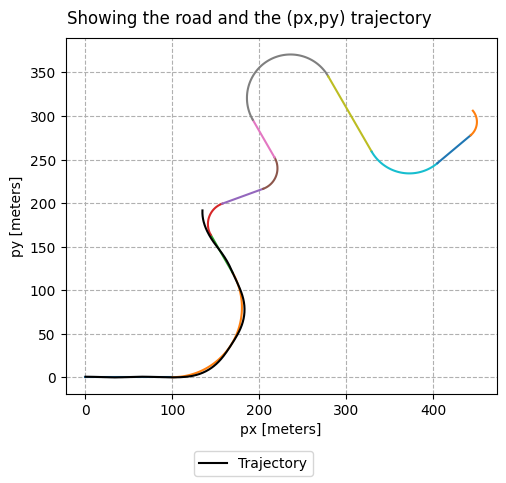

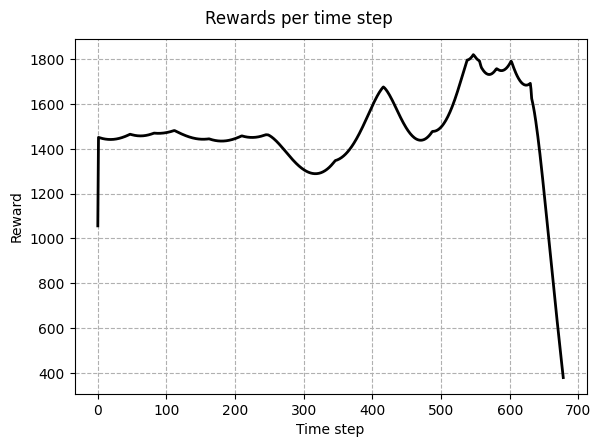

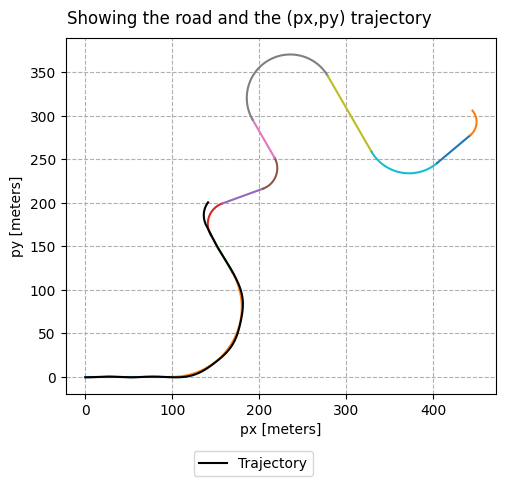

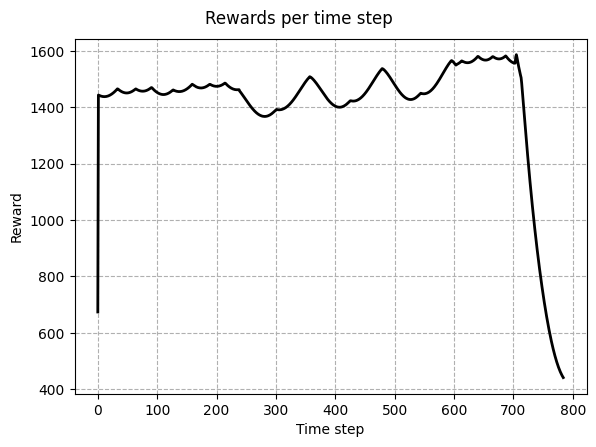

In [ ]:
def optimize_ppo(trial):
    """ Learning hyperparameters we want to optimise"""
    return {
        'learning_rate': trial.suggest_categorical('learning_rate', [0.0003, 0.003, 0.03]),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
        'clip_range': trial.suggest_categorical('clip_range', [0.1, 0.25, 0.4]),
        #reward coeffs.
    }

def objective(trial):
    """ Objective function for optimization """
    model = eval(f"{RL_MODEL}(\"MultiInputPolicy\", env, verbose=1, tensorboard_log=logdir, **optimize_ppo(trial))")

    # print(f"COMBINATION {trial}")
    # print(eval_model.__module__)

    params = optimize_ppo(trial)
    print(f"Current trial parameters: {params}")

    model.learn(total_timesteps=TIMESTEPS_PER_EPOCH, reset_num_timesteps=False, tb_log_name=f"{model_name}")

    eval_model(env, model, figs_dir, TIMESTEPS_PER_EPOCH * 1)

    return 1

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=27, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Select Policy

In [ ]:
model = eval(f"{RL_MODEL}(\"MultiInputPolicy\", env, verbose=1, tensorboard_log=logdir)")
# model = eval(f"{RL_MODEL}(\"MultiInputLstmPolicy\", env, verbose=1, tensorboard_log=logdir)")

TypeError: ignored

Tensorboard setup

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs
#%reload_ext ensorfboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-11-09 04:36:41.497093: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-09 04:36:41.497172: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-09 04:36:41.497216: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-09 04:36:42.923854: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorf

Training Loop

epoch 1
Logging to logs/PPO_1_0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.road to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.road` for environment variables or `env.get_wrapper_attr('road')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.car to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.car` for environment variables or `env.get_wrapper_attr('car')` that will search the rem

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 89.7     |
|    ep_rew_mean     | 7.67e+04 |
| time/              |          |
|    fps             | 127      |
|    iterations      | 1        |
|    time_elapsed    | 16       |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 141        |
|    ep_rew_mean          | 7.77e+04   |
| time/                   |            |
|    fps                  | 174        |
|    iterations           | 2          |
|    time_elapsed         | 23         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00126084 |
|    clip_fraction        | 0.000732   |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.84      |
|    explained_variance   | 1.07e-06   |
|    learning_rate        | 0.0003     |
|   

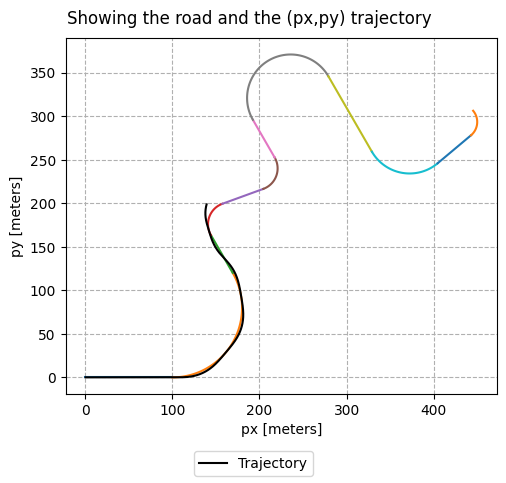

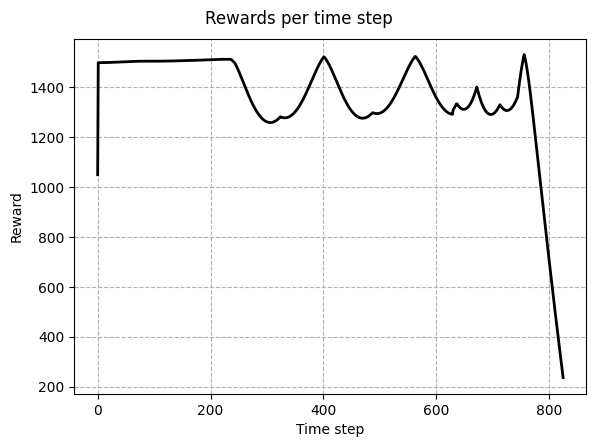

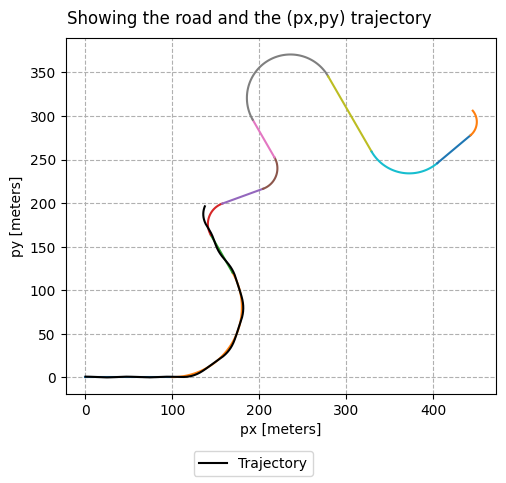

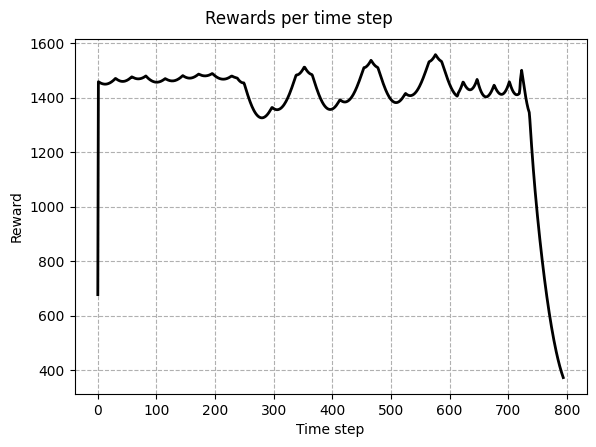

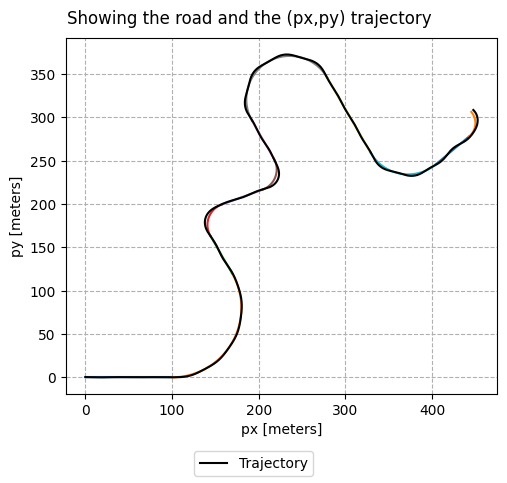

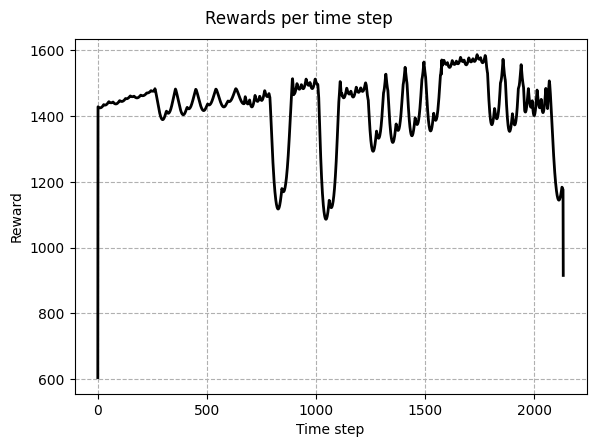

In [ ]:
for i in range(1, EPOCHS+1):
    print(f"epoch {i}")
    model.learn(
        total_timesteps=TIMESTEPS_PER_EPOCH,
        reset_num_timesteps=False,
        tb_log_name=f"{model_name}"
    )
    model.save(f"{models_dir}/{TIMESTEPS_PER_EPOCH * i}")
    eval_model(env, model, figs_dir, TIMESTEPS_PER_EPOCH * i)

## Experimenting with Different Policies:

Which policy to use? Check here: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html

In [ ]:
# from stable_baselines3 import PPO, SAC, DDPG

# model = PPO("MultiInputPolicy", env, verbose = 1)
# #model = SAC("MultiInputPolicy", env, verbose = 1)
# #model = DDPG("MultiInputPolicy", env, verbose = 1)

Custom Policies:

Read up more here: https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html


In [ ]:
# # Define hidden layer dimensions
# policy_kwargs = dict(net_arch=[128, 128])

# # Define differente hidden layer dimensions for the actor and the critic
# #policy_kwargs = dict(net_arch=dict(pi=[32, 32], vf=[64, 64]))


# # Define custom activation funcitons (not recommended for our problem)
# # import torch as th

# # Custom MLP policy of two layers of size 32 each with Relu activation function
# # policy_kwargs = dict(activation_fn=th.nn.ReLU, net_arch=[32, 32])

# model = PPO("MultiInputPolicy", env, policy_kwargs = policy_kwargs, verbose = 1)

## What to Do?

- Experiment with Custom Observations
- You are encouraged to design/develop your own Rewards
- Experiment with different Policies: PPO/SAC/DDPG, etc.   
- You can also experiment with different policy architectures (changing the hidden layer dimensions etc.)
- Evaluate and test your model on a different road (You are also encouraged to train on a more difficult road so that the model learns better)


## Evaluation & Testing on a Different Road

In [ ]:
class TestRewardWrapper(gym.RewardWrapper):
    def __init__(self, env):
        super(TestRewardWrapper, self).__init__(env)

    def reward(self, reward):
        """"
        Modified Binary Reward Function
        Returns 1 if the car is within 1m of the center of the line
        Returns 0 if the car is outside the center of the line
        """
        info_dict = self.env.road.road_info_at_given_pose_and_progress_queries(
            px=self.env.car.px, py=self.env.car.py, theta=self.env.car.theta, progress_queries=self.progress_queries)

        distance = info_dict['closest_distance']
        if distance <= 1:
            return 1
        else:
            return 0

In [ ]:
# Create a new road

# road_elements_list = [
#     {"type":"straight", "length":200.0},
#     {"type":"curved", "curvature":-1/50.0, "angle_in_degrees":180.0},
#     {"type":"straight", "length":200.0},
#     {"type":"curved", "curvature":1/100.0, "angle_in_degrees":180.0},
#     {"type":"straight", "length":100.0},
# ]

road_elements_list = [
    {"type":"straight", "length":100.0},
    {"type":"curved", "curvature":-1/25.0, "angle_in_degrees":140.0},
    {"type":"straight", "length":100.0},
    {"type":"curved", "curvature":1/40.0, "angle_in_degrees":180.0},
    {"type":"straight", "length":130.0},
    {"type":"curved", "curvature":1/15.0, "angle_in_degrees":45.0},
    {"type":"straight", "length":50.0},
]

In [ ]:
env = gym.make(
    "ai4rgym/autonomous_driving_env",
    render_mode=None,
    bicycle_model_parameters=bicycle_model_parameters,
    road_elements_list=road_elements_list,
    numerical_integration_parameters=numerical_integration_parameters,
    initial_state_bounds=initial_state_bounds,
)

env = FlattenActionWrapper(env)
env = gym.wrappers.RescaleAction(env, min_action=-1, max_action=1)
env = CustomObservationWrapper(env)
#env = CustomRewardWrapper(env)
env = TestRewardWrapper(env)
env = TerminateTruncateWrapper(env)

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.integration_Ts to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.integration_Ts` for environment variables or `env.get_wrapper_attr('integration_Ts')` that will search the reminding wrappers.
  logger.warn(


In [ ]:
# model_path = 'models/PPO_1/260000'
LOAD_EPOCH_NUM = 4

model_path = f'models/{model_name}/{TIMESTEPS_PER_EPOCH*LOAD_EPOCH_NUM}'

model = eval(f"{RL_MODEL}.load(model_path, env)")

timestep = TIMESTEPS_PER_EPOCH * LOAD_EPOCH_NUM
figs_dir = f'models/{model_name}/eval'

ensure_dir(figs_dir)

FileNotFoundError: ignored

In [ ]:
eval_model(env, model, figs_dir, timestep)

In [ ]:
!zip -r /content/ai4r-gym/result.zip /content/ai4r-gym/models
from google.colab import files
files.download("/content/ai4r-gym/result.zip")

In [ ]:
import random

def generate_random_numbers(num_values, avg_value, range_value):
    random_numbers = []

    for _ in range(num_values):
        value = random.gauss(avg_value, range_value)
        random_numbers.append(max(0, min(17500, int(value))))

    return random_numbers

num_values = 54  # Number of random values to generate
avg_value = 12000  # Desired average value
range_value = 3000  # Range of values around the average

random_numbers = generate_random_numbers(num_values, avg_value, range_value)

print(random_numbers)

[12839, 10401, 17123, 16260, 12491, 9899, 10434, 11517, 11230, 15974, 11573, 10334, 12670, 13188, 13760, 12909, 10733, 11516, 11311, 14888, 8991, 12005, 13364, 9782, 12486, 11732, 11272, 11581, 16313, 11843, 10500, 8702, 9378, 9847, 17154, 13958, 15954, 9042, 9756, 9145, 12397, 12537, 13687, 8523, 16539, 9239, 13712, 9004, 14397, 9305, 13194, 13133, 14747, 12953]


In [ ]:
print([12839, 10401, 17123, 16260, 12491, 9899, 10434, 11517, 11230, 15974, 11573, 10334, 12670, 13188, 13760, 12909, 10733, 11516, 11311, 14888, 8991, 12005, 13364, 9782, 12486, 11732, 11272, 11581, 16313, 11843, 10500, 8702, 9378, 9847, 17154, 13958, 15954, 9042, 9756, 9145, 12397, 12537, 13687, 8523, 16539, 9239, 13712, 9004, 14397, 9305, 13194, 13133, 14747, 12953])